# Evaluating Bivariate Confidence Intervals

- Sample distribution behavior 


In [1]:
addpath(genpath('~/Code/matlabTools/plotTools'));

### Sample distribution behavior

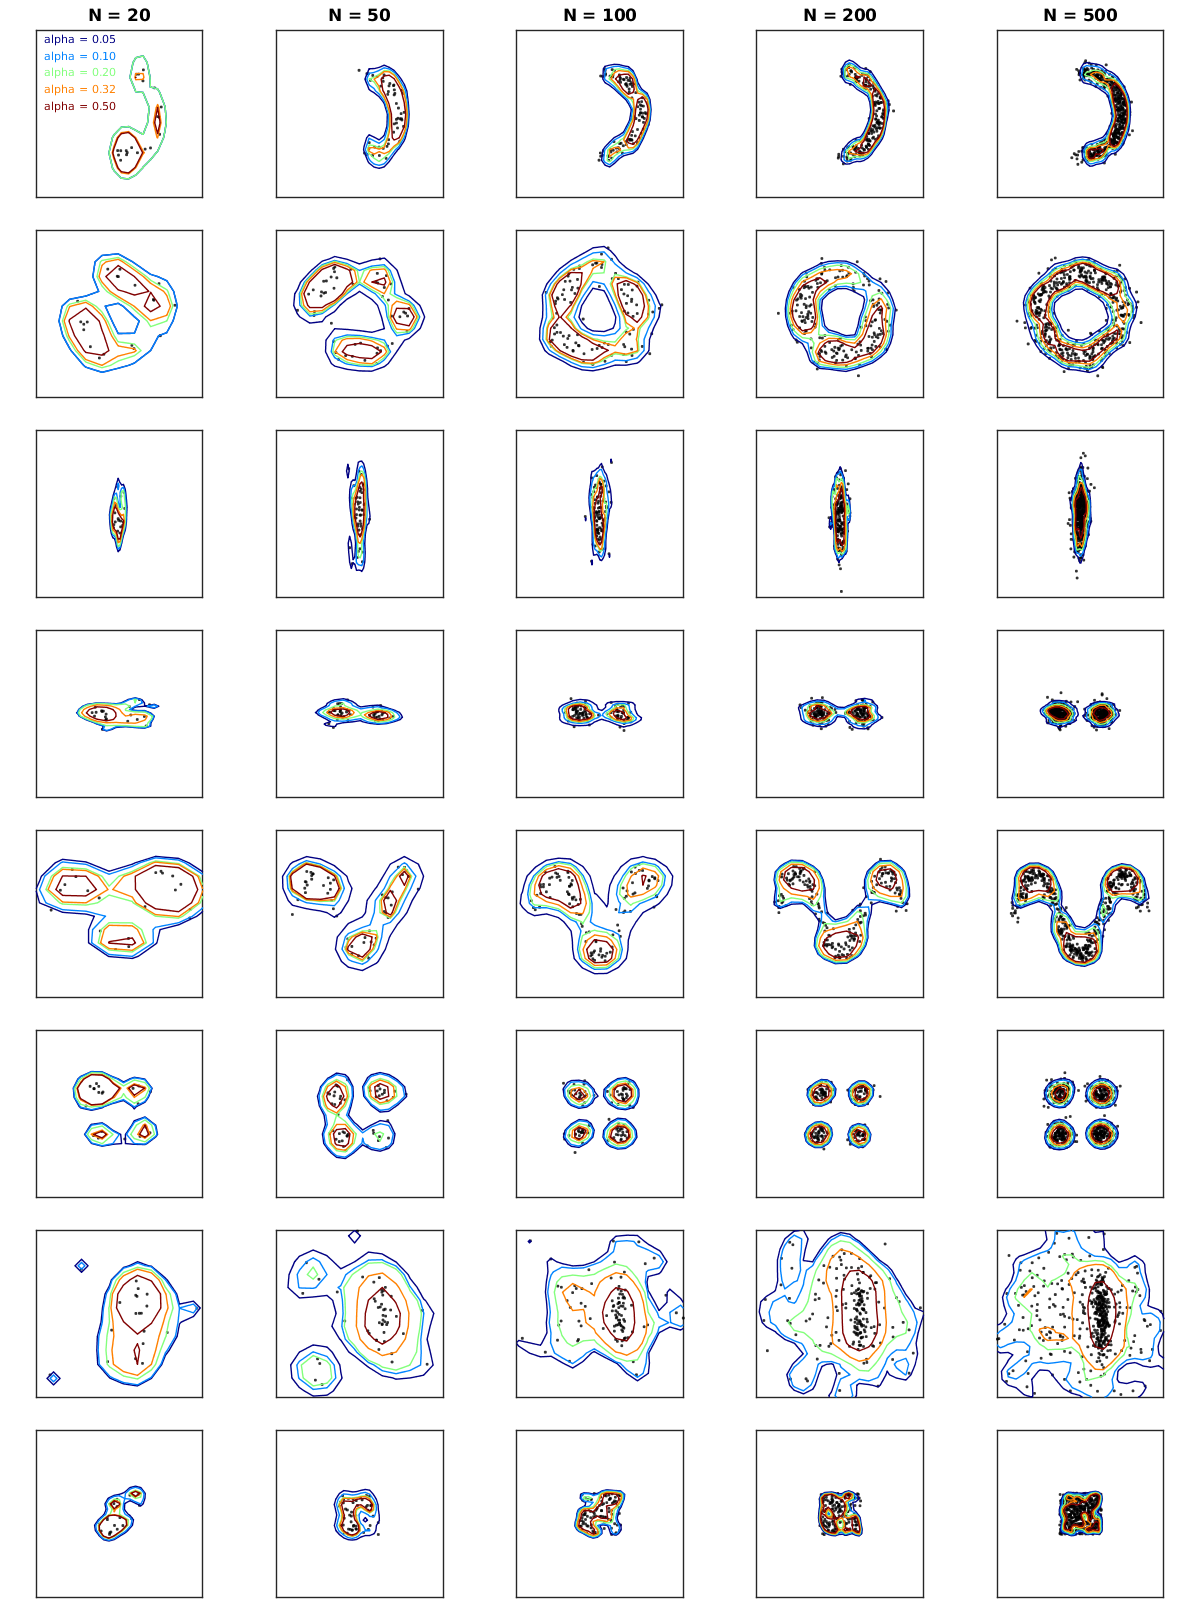

In [2]:
%plot inline -s 1200,1600 -r 200

method = @(points, alpha) histogramConfidence(points, alpha,'SmoothBins',1,'Upsample',3);
% method = @(points, alpha) kdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',1);
% method = @(points, alpha) adaptiveKdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',2);

nSamplesList = [20,50,100,200,500];
testSamples = 10000;
% alpha = 1 - 0.683; % Standard error
alphaList = [0.05, 0.10, 0.20, 1 - 0.683, 0.50];
alphaColors = spaceColorMap(1:length(alphaList),length(alphaList), jet);

nTestDistributions = 8;
tS = tightSubplot(nTestDistributions,length(nSamplesList),[.05 .05 .01 .15]);
for distN = 1:nTestDistributions
    for nSamplesN = 1:length(nSamplesList)
        nSamples = nSamplesList(nSamplesN);
        fitPoints = testDistributions(distN, nSamples);
        
        tS.getSubplot(distN, nSamplesN);
        plotPoints = fitPoints;                   
        scatter(plotPoints(:,1),plotPoints(:,2),1,'k.','MarkerEdgeAlpha',.8); hold on;
        if distN == 1
            title(sprintf('N = %d',nSamples),'FontSize',6);
        end
        
        for alphaN = 1:length(alphaList)
            alpha = alphaList(alphaN);

            % Fit empiric CI to fitPoints
            M = method(fitPoints,alpha);

            % Plot empiric CI
            h = plotContour(M, 'FaceColor','None','EdgeColor',alphaColors(alphaN,:)); 
            axis equal; box on; xlim([-2 2]); ylim([-2 2]);
            set(gca,'XTick',[],'YTick',[]);
        end

    end
end
tS.getSubplot(1);
for textN = 1:length(alphaList)
    alpha = alphaList(textN);
    text(-1.8, 1.8 - 0.4*(textN - 1), sprintf('alpha = %.2f', alpha),'Color',alphaColors(textN,:),'FontSize',4);
end

tightPrint(gcf, 'methodSamplePerformance.pdf');

### Comparison methodology

We'll repeatedly construct estimates of the 95% CI for these distributions from samples of [20, 50, 100, 200, 500, 1000] points, and then measure coverage by determining how many of 10,000 other samples of the distribution fall within those CIs. For each distribution at each sampling level we'll construct a histogram of coverage error.

In [3]:
ciMethods{1} = @(points, alpha) histogramConfidence(points, alpha, 'SmoothBins',1,'Upsample',3);
ciMethods{2} = @(points, alpha) kdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',1);
ciMethods{3} = @(points, alpha) adaptiveKdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',0.5);
ciMethods{4} = @(points, alpha) adaptiveKdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',1);
ciMethods{5} = @(points, alpha) adaptiveKdeConfidence(points, alpha, 'Resolution',[.05,.05],'ScaleBandwidth',2);

methodColors = spaceColorMap(1:length(ciMethods),length(ciMethods),jet);

In [5]:
%plot inline -s 1200,1600 -r 200
nSamplesList = [20,50,100,200,500];
testSamples = 10000;
% alpha = 1 - 0.683; % Standard error
alpha = 0.05;
testReps = 1000;

% Array to store the results
coverage = zeros(length(distributions),length(nSamplesList),length(ciMethods),testReps);

for distN = 1:length(distributions)
    for nSamplesN = 1:length(nSamplesList)
        nSamples = nSamplesList(nSamplesN);
 
        for methodN = 1:length(ciMethods)
            method = ciMethods{methodN};
        
            for repN = 1:testReps
                fitPoints = testDistributions(distN,nSamples);
                testPoints = testDistributions(distN,testSamples);

                % Fit empiric CI to fitPoints
                M = method(fitPoints,alpha);
                contourMs{distN,nSamplesN,methodN} = M;

                % Find points in empiric CI
                poly = contourToPolygon(M);
                coveredPoints = inpolygon(testPoints(:,1),testPoints(:,2),poly(:,1),poly(:,2));
                coverage(distN, nSamplesN, methodN, repN) = nnz(coveredPoints)/testSamples;
                
                if (repN == 1)
                    fprintf('Distribution # %d   Sample size: %d   Method: %d   Coverage: %.3f\n',...
                        distN,nSamples,methodN,coverage(distN, nSamplesN, methodN, repN));
                end
            end
            
        end
    end
end

save('evaluateCoverage.mat','coverage','alpha','contourMs','ciMethods');

Error using eval
Unrecognized function or variable 'distributions'.



In [ ]:
load('evaluateCoverage.mat');
testReps = size(coverage,4)

In [ ]:
tS = tightSubplot(length(distributions),length(nSamplesList));
for distN = 1:length(distributions)
    dist = distributions{distN};
    for nSamplesN = 1:length(nSamplesList)
        nSamples = nSamplesList(nSamplesN);
        for methodN = 1:length(ciMethods)
            method = ciMethods{methodN};

            tS.getSubplot(distN,nSamplesN);
            meanCoverage = mean(coverage(distN,nSamplesN,methodN,:));
            stdCoverage = std(coverage(distN,nSamplesN,methodN,:));
            histogram(1 - coverage(distN,nSamplesN,methodN,:),linspace(0,2*alpha,20),...
                'DisplayStyle','stairs','EdgeColor',methodColors(methodN,:),...
                'Normalization','probability'); hold on;
            axis tight;
            plot(alpha*[1,1],ylim(),'k--'); box off;
            
            set(gca,'XTick',[0,alpha,2*alpha],'YTick',[],'XTickLabels',{},'TickDir','out');
        end
    end
end
for methodN = 1:length(ciMethods)
    text(0.05,diff(ylim)-.05*(methodN-1),sprintf('%d',methodN),'Color',methodColors(methodN,:),'FontSize',6);
end

In [ ]:

for distN = 1:length(distributions)
    dist = distributions{distN};
    for methodN = 1:length(ciMethods)
        method = ciMethods{methodN};

        subplot(length(distributions),1,distN);
        subCover = squeeze(coverage(distN,:,methodN,:));
        xPoints = nSamplesList'*ones(1,testReps);
        h = drawUnivariateConfidenceInterval(xPoints, subCover, @(x) std(x), @(x) mean(x)); hold on;
        h(1).EdgeColor = 'None';
        h(1).FaceColor = methodColors(methodN,:);
        h(1).FaceAlpha = 0.3;
        h(2).Color = methodColors(methodN,:);
        set(gca,'XScale','log','XTick',nSamplesList,'XTickLabels',[],...
            'YTick',1 - alpha*[2,1,0],'TickDir','out');
        axis tight;
        ylim(1 - [2*alpha, 0]);
        xlim([min(nSamplesList) max(nSamplesList)]);

    end
    plot(xlim(),1 - alpha*[1,1],'k--');
end
set(gca,'XTickLabels',nSamplesList);
xlabel('Samples for Fitting');
ylabel('Coverage');
